In [1]:
# 먼저 데이터가 저장된 폴더를 연결합시다.
!mkdir -p aiffel/time_series_basic
!cp data/AirPassengers.csv aiffel/time_series_basic/

cp: cannot stat 'data/AirPassengers.csv': No such file or directory


In [2]:
!pip install tsfresh

In [ ]:
# 라이브러리 버전 충돌을 피하기 위해 런타임을 재시작합니다.
import os
os.kill(os.getpid(), 9)

In [1]:
# 라이브러리를 불러옵니다.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# air passengers 데이터를 불러옵니다.
ap = pd.read_csv('/aiffel/aiffel/time_series_basic/AirPassengers.csv')

# 'Month' column을 삭제합니다.
ap.drop('Month', axis = 1, inplace = True)

In [3]:
ap

,#Passengers
0,112
1,118
2,132
3,129
4,121
...,...
139,606
140,508
141,461
142,390


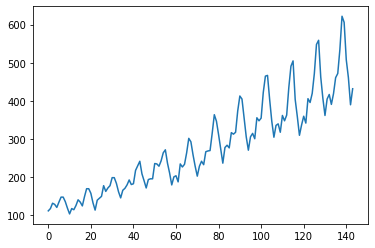

In [4]:
plt.figure()
plt.plot(ap)
plt.show()

In [5]:
# np.log를 통해서 log transformation
log_transformed = np.log1p(ap) # np.log

In [6]:
log_transformed

,#Passengers
0,4.727388
1,4.779123
2,4.890349
3,4.867534
4,4.804021
...,...
139,6.408529
140,6.232448
141,6.135565
142,5.968708


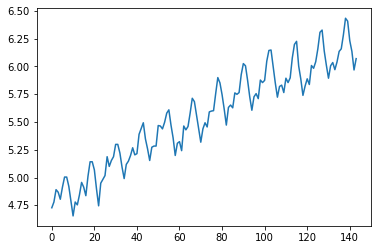

In [7]:
# 분산이 일정해진 것을 눈으로 확인할 수 있습니다.
plt.figure()
plt.plot(log_transformed)
plt.show()

In [8]:
# diff() 함수를 통해 간단하게 차분을 수행할 수 있습니다.
## 
diffed = log_transformed.diff()[1:] #차분을 하면 null값이 들어갈 수 있는데 제거해야함.

In [9]:
diffed

,#Passengers
1,0.051736
2,0.111226
3,-0.022815
4,-0.063513
5,0.108634
...,...
139,-0.026018
140,-0.176081
141,-0.096883
142,-0.166857


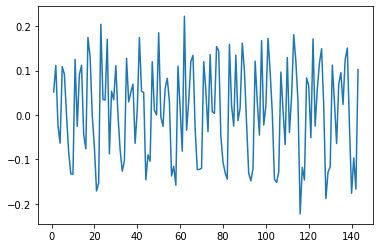

In [10]:
# 커지는 분산과 증가하는 추세를 제거한 air passengers 데이터를 얻을 수 있습니다.
plt.figure()
plt.plot(diffed)
plt.show()

In [11]:
# diff에 12라는 값을 넣어주면 주기를 12로 하는 계절 차분을 수행할 수 있습니다.
seasonally_diffed = diffed.diff(12)
# 차분을 하면 데이터가 짧아지기 때문에 빈칸을 제거해야 합니다.
seasonally_diffed.dropna(inplace = True)

In [12]:
# 형태를 확인해봅시다.
seasonally_diffed

,#Passengers
13,0.038861
14,0.000414
15,-0.020357
16,-0.012860
17,0.065720
...,...
139,-0.045856
140,0.011971
141,0.031734
142,-0.049993


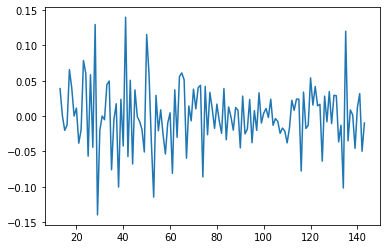

In [13]:
# 아래와 같은 데이터를 얻을 수 있습니다.
plt.figure()
plt.plot(seasonally_diffed)
plt.show()

In [14]:
from statsmodels.tsa.stattools import adfuller

def adf_test(x): # adf검정을 위한 함수 정의
    stat, p_value, lags, nobs, crit, icb = adfuller(x) # adfuller 함수를 이용하면 6가지 output이 나옵니다.
    print('ADF statistics')
    print(stat) # ADF 검정 통계량입니다.
    print('P-value')
    print(p_value) # P-value입니다.

In [15]:
# 계절차분까지 수행한 데이터로 adf 테스트를 수행합니다.
adf_test(seasonally_diffed)

ADF statistics
-4.443327165907629
P-value
0.0002485889575086046


In [16]:
# ⑥-1 : 데이터 다운로드 및 불러오기
from tsfresh.examples.robot_execution_failures import download_robot_execution_failures, load_robot_execution_failures

# robot exection failures 데이터를 불러옵니다.
download_robot_execution_failures()
timeseries, y = load_robot_execution_failures()

In [17]:
# ⑥-2 : 데이터셋 확인(timeseries와 y 확인)
timeseries # id, time을 제외하고 6개 column의 X변수가 나타납니다.

,id,time,F_x,F_y,F_z,T_x,T_y,T_z
0,1,0,-1,-1,63,-3,-1,0
1,1,1,0,0,62,-3,-1,0
2,1,2,-1,-1,61,-3,0,0
3,1,3,-1,-1,63,-2,-1,0
4,1,4,-1,-1,63,-3,-1,0
...,...,...,...,...,...,...,...,...
1315,88,10,-10,2,39,-21,-24,5
1316,88,11,-11,2,38,-24,-22,6
1317,88,12,-12,3,23,-24,-24,5
1318,88,13,-13,4,26,-29,-27,5


In [18]:
y # true/false가 제시되어 있습니다.

1      True
2      True
3      True
4      True
5      True
      ...  
84    False
85    False
86    False
87    False
88    False
Length: 88, dtype: bool

In [19]:
# ⑥-3 : 데이터셋 가공
def custom_classification_split(x,y,test_size=0.3): # 수업 때 보았던 custom split 함수
    
    num_true = int(y.sum()*test_size)
    num_false = int((len(y)-y.sum())*test_size)
    
    id_list = y[y==False].head(num_false).index.to_list() + y[y==True].head(num_true).index.to_list()
    
    y_train = y.drop(id_list)
    y_test = y.iloc[id_list].sort_index()
    X_train = timeseries[~timeseries['id'].isin(id_list)]
    X_test = timeseries[timeseries['id'].isin(id_list)]
    
    return X_train, y_train, X_test, y_test

In [20]:
# ⑥-4 : 데이터셋 나누기
# test set의 비율을 0.25로 지정해주세요.
X_train, y_train, X_test, y_test = custom_classification_split(timeseries, y, test_size = 0.25)

In [21]:
from tsfresh import extract_features
from tsfresh.feature_extraction import EfficientFCParameters
from tsfresh.utilities.dataframe_functions import impute

settings = EfficientFCParameters()

In [22]:
# ⑥-5 : Feature extraction
comprehensive_features_train = extract_features(
                                    X_train, 
                                    column_id="id",
                                    column_sort="time",
                                    default_fc_parameters=settings
                                          )

Feature Extraction: 100%|██████████| 402/402 [00:16<00:00, 24.02it/s]


In [23]:
comprehensive_features_test = extract_features(
                                    X_test, 
                                    column_id="id",
                                    column_sort="time",
                                    default_fc_parameters=settings
                                          )

Feature Extraction: 100%|██████████| 126/126 [00:05<00:00, 24.74it/s]


In [24]:
# ⑥-6 : impute
impute(comprehensive_features_train)

/opt/conda/lib/python3.9/site-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['F_x__partial_autocorrelation__lag_7'
 'F_x__partial_autocorrelation__lag_8'
 'F_x__partial_autocorrelation__lag_9' ...
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"'
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"'
 'T_z__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


,F_x__variance_larger_than_standard_deviation,F_x__has_duplicate_max,F_x__has_duplicate_min,F_x__has_duplicate,F_x__sum_values,F_x__abs_energy,F_x__mean_abs_change,F_x__mean_change,F_x__mean_second_derivative_central,F_x__median,...,T_z__fourier_entropy__bins_5,T_z__fourier_entropy__bins_10,T_z__fourier_entropy__bins_100,T_z__permutation_entropy__dimension_3__tau_1,T_z__permutation_entropy__dimension_4__tau_1,T_z__permutation_entropy__dimension_5__tau_1,T_z__permutation_entropy__dimension_6__tau_1,T_z__permutation_entropy__dimension_7__tau_1,T_z__query_similarity_count__query_None__threshold_0.0,T_z__mean_n_absolute_max__number_of_maxima_7
6,1.0,1.0,1.0,1.0,-15.0,39.0,1.714286,0.142857,0.153846,-1.0,...,0.974315,1.213008,1.732868,1.438883,1.863680,2.145842,2.163956,2.197225,0.0,0.714286
7,0.0,1.0,0.0,1.0,-13.0,21.0,0.928571,0.214286,-0.076923,-1.0,...,1.255482,1.494175,2.079442,1.043794,1.349792,1.666333,1.748067,1.831020,0.0,0.428571
8,1.0,0.0,1.0,1.0,-10.0,26.0,1.142857,-0.142857,0.192308,-1.0,...,1.494175,1.732868,2.079442,1.412745,2.138333,2.397895,2.302585,2.197225,0.0,1.285714
9,1.0,0.0,0.0,1.0,-10.0,24.0,1.428571,0.000000,-0.076923,-1.0,...,1.255482,1.494175,2.079442,1.479133,2.138333,2.397895,2.302585,2.197225,0.0,1.285714
10,0.0,0.0,1.0,1.0,-14.0,14.0,0.142857,0.000000,0.000000,-1.0,...,0.937285,1.213008,1.906155,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,1.0,1.0,0.0,1.0,-1073.0,96833.0,7.142857,-5.428571,-0.038462,-98.0,...,0.735622,0.735622,1.386294,1.585771,2.253858,2.397895,2.302585,2.197225,0.0,24.285714
85,1.0,0.0,1.0,1.0,143.0,1683.0,1.357143,1.071429,0.076923,8.0,...,0.735622,0.735622,1.667462,1.332245,1.589027,1.893788,2.163956,2.197225,0.0,5.571429
86,1.0,0.0,0.0,0.0,961.0,83497.0,9.071429,9.071429,0.807692,52.0,...,0.735622,1.073543,1.732868,0.687092,0.983088,1.159589,1.227529,1.303092,0.0,9.285714
87,1.0,1.0,0.0,1.0,4509.0,1405437.0,12.928571,12.214286,-1.038462,338.0,...,0.735622,0.735622,1.386294,0.535961,0.836988,1.159589,1.497866,1.581094,0.0,40.285714


In [25]:
impute(comprehensive_features_test)

/opt/conda/lib/python3.9/site-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['F_x__partial_autocorrelation__lag_7'
 'F_x__partial_autocorrelation__lag_8'
 'F_x__partial_autocorrelation__lag_9' ...
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"'
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"'
 'T_z__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


,F_x__variance_larger_than_standard_deviation,F_x__has_duplicate_max,F_x__has_duplicate_min,F_x__has_duplicate,F_x__sum_values,F_x__abs_energy,F_x__mean_abs_change,F_x__mean_change,F_x__mean_second_derivative_central,F_x__median,...,T_z__fourier_entropy__bins_5,T_z__fourier_entropy__bins_10,T_z__fourier_entropy__bins_100,T_z__permutation_entropy__dimension_3__tau_1,T_z__permutation_entropy__dimension_4__tau_1,T_z__permutation_entropy__dimension_5__tau_1,T_z__permutation_entropy__dimension_6__tau_1,T_z__permutation_entropy__dimension_7__tau_1,T_z__query_similarity_count__query_None__threshold_0.0,T_z__mean_n_absolute_max__number_of_maxima_7
1,0.0,0.0,1.0,1.0,-14.0,14.0,0.142857,0.000000,-0.038462,-1.0,...,1.073543,1.440235,2.079442,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.0,0.000000
2,0.0,1.0,1.0,1.0,-13.0,25.0,1.000000,0.000000,-0.038462,-1.0,...,1.073543,1.494175,2.079442,0.937156,1.234268,1.540306,1.748067,1.831020,0.0,0.571429
3,0.0,0.0,1.0,1.0,-10.0,12.0,0.714286,0.000000,-0.038462,-1.0,...,1.386294,1.732868,2.079442,1.265857,1.704551,2.019815,2.163956,2.197225,0.0,0.571429
4,0.0,1.0,1.0,1.0,-6.0,16.0,1.214286,-0.071429,-0.038462,0.0,...,1.073543,1.494175,2.079442,1.156988,1.907284,2.397895,2.302585,2.197225,0.0,1.000000
5,0.0,0.0,0.0,1.0,-9.0,17.0,0.928571,-0.071429,0.038462,-1.0,...,0.900256,1.320888,2.079442,1.156988,1.863680,2.271869,2.302585,2.197225,0.0,0.857143
19,1.0,0.0,0.0,1.0,99.0,6109.0,13.928571,-1.928571,-1.730769,1.0,...,0.974315,1.494175,1.906155,1.230932,1.704551,2.019815,2.025326,2.043192,0.0,1.428571
20,1.0,0.0,1.0,1.0,155.0,34455.0,16.714286,-13.142857,7.576923,-1.0,...,1.386294,1.667462,2.079442,1.564957,2.022809,2.271869,2.302585,2.197225,0.0,2.571429
21,1.0,0.0,0.0,1.0,-171.0,16495.0,20.928571,1.785714,3.961538,-1.0,...,0.735622,0.735622,0.735622,1.303876,1.791759,2.271869,2.302585,2.197225,0.0,17.285714
22,1.0,0.0,0.0,1.0,102.0,12700.0,10.785714,-8.071429,4.500000,-1.0,...,0.562335,0.735622,1.732868,1.524707,2.138333,2.397895,2.302585,2.197225,0.0,5.428571
23,1.0,0.0,0.0,1.0,67.0,10593.0,15.142857,-7.000000,3.000000,-3.0,...,0.974315,1.255482,2.079442,1.519383,2.369382,2.397895,2.302585,2.197225,0.0,3.714286


In [26]:
# ⑥-7 : RandomForest 사용 및 score 확인
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators = 10, max_depth = 3)

rf_clf.fit(comprehensive_features_train, y_train)

RandomForestClassifier(max_depth=3, n_estimators=10)

In [28]:
# test셋에 적합해본 결과 약 0.66의 정확도를 보이며 불만족스러운 결과를 확인할 수 있습니다. (그런데 지금은 0.8 나오는데? 준수한데?)
rf_clf.score(comprehensive_features_test, y_test)

0.8095238095238095

In [29]:
# ⑥-7 : XGBoost 사용 및 score 확인
import xgboost as xgb
xgb_clf = xgb.XGBClassifier(n_estimators = 10, max_depth = 3)

# XGBoost 모델을 학습시킵니다.
xgb_clf.fit(comprehensive_features_train, y_train)

/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[07:19:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=10, n_jobs=2, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [30]:
# XGBoost 모델의 score를 확인합니다.
xgb_clf.score(comprehensive_features_test, y_test)

1.0

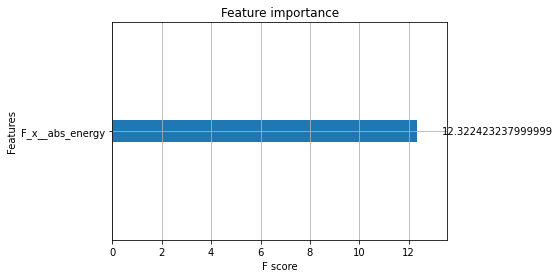

In [31]:
# ⑥-8 : XGBoost plot_importance 확인 및 시각화
# plot_importance를 통해 어떤 변수(특징)가 가장 유의미한지 확인합니다.
xgb.plot_importance(xgb_clf, importance_type = 'gain')
plt.show()

In [32]:
sum(xgb_clf.feature_importances_ != 0) # Fx 값의 abs_energy 특징만의 유의미함

1

In [33]:
# ⑥-9 : Classification report를 통한 검증 및 분석
from sklearn.metrics import classification_report

classification_report(y_test, xgb_clf.predict(comprehensive_features_test), target_names = ['true', 'false'], output_dict = True)

{'true': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 16},
 'false': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 5},
 'accuracy': 1.0,
 'macro avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 21},
 'weighted avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 21}}

- mini test라서 코드를 따라 쳐보긴 했다.
- EfficientFCParameters() 이 모델 말고 Comperhensive 썼더라면? (지금은 충분히 좋은 성능을 보이지만, 후에 쓸 일이 생길 것 같다.)
- Log-transformation 부분은 원활한 처리를 위해 np.log 대신 np.log1p를 선호해서 이 코드를 사용했다.
- 가장 많이 쓰이는 검정이 ADF 검정이라고 한다.(실제 시계열 이론 책에서도 R을 사용했었는데, 검정 과정은 대부분 ADF를 사용했던 것 같다.)
- precision, recalll, f1-score 모두 1.0이라서 건드릴 수가 없었다...
- logistic 사용을 강사님이 해주셨을 떈 0.66이 나왔다고 했는데 내가 돌렸을 땐 0.8이 나왔다. 왜 갑자기 성능이 좋아졌지???
- train, test 추출 과정에서 운이 좋았던 거라고 생각을 한다. 
- 후에 생존분석과 시계열이 같이 쓰이는 부분이 있으면 좀 더 깊게 공부해 보고 싶다.